# WRF-Chem Results Evaluation

## Libraries

In [2]:
%matplotlib inline
from functools import reduce
import pandas as pd
import os, fnmatch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib as mpl


# Import Data

### Measured data in CETESB stations

In [3]:
stations = pd.read_csv('../1_ObsData/stations.csv')
    #                  encoding = "ISO-8859-1")
stations

,name,lat,lon,code,type,domain,abb
0,Americana,-22.724253,-47.339549,290,Sub-urban,d02,Ame
1,Araçatuba,-21.186841,-50.439317,107,Sub-urban,d01,Ara
2,Araraquara,-21.782522,-48.185832,106,Sub-urban,d02,Arrq
3,Bauru,-22.326608,-49.092759,108,Sub-urban,d01,Bau
4,Cambuci,-23.567708,-46.612273,90,Urban road,d02,Cmb
...,...,...,...,...,...,...,...
64,Sorocaba,-23.502427,-47.479030,67,Sub-urban,d02,Srcb
65,Taboão da Serra,-23.609324,-46.758294,103,Urban road,d02,TdS
66,Tatuí,-23.360752,-47.870799,256,Sub-urban,d02,Tt
67,Taubaté,-23.032351,-45.575805,280,Sub-urban,d02,Tbt


In [4]:
# Meteorological parameters observations
Dir = '../1_ObsData/SEP18/'

def readDat(files, path = '../1_ObsData/SEP18/',time_zone="America/Sao_Paulo"):
    Data = pd.DataFrame()
    for file in files:
        df = pd.read_csv(path + file)
        Data = pd.concat([Data,df])
    Data['station'] = [stations[stations.code == i].name.values[0] for i in Data.code]
    Data.loc[:,'date'] = pd.to_datetime(Data['date'], format='%Y-%m-%d %H:%M:%S')
    Data.rename(columns={'date':'local_date'}, inplace = True)
    Data.loc[:,'local_date']=Data['local_date'].dt.tz_localize(time_zone)
    return Data

f18 = fnmatch.filter(os.listdir(Dir), 'all_met*.csv')
metObs = readDat(f18, path = Dir)

# Air quality parameters
f18 = fnmatch.filter(os.listdir(Dir), 'all_photo*.csv')
aqObs = readDat(f18, path = Dir)


In [5]:
Obs = pd.merge(metObs, aqObs)
Obs['nox']=Obs.no+Obs.no2
Obs['Mday']= Obs.local_date.dt.strftime('%b-%d-%H')
Obs[Obs.station == "São José do Rio Preto"]

,local_date,tc,rh,sr,ws,wd,code,station,o3,no,no2,co,nox,Mday
26677,2018-09-01 00:00:00-03:00,NaN,NaN,NaN,NaN,NaN,116,São José do Rio Preto,NaN,NaN,NaN,NaN,NaN,Sep-01-00
26678,2018-09-01 01:00:00-03:00,23.2,56.0,0.0,1.0,46.0,116,São José do Rio Preto,0.0,NaN,NaN,NaN,NaN,Sep-01-01
26679,2018-09-01 02:00:00-03:00,23.6,50.0,0.0,1.3,38.0,116,São José do Rio Preto,3.0,20.0,55.0,NaN,75.0,Sep-01-02
26680,2018-09-01 03:00:00-03:00,23.8,48.0,0.0,0.9,68.0,116,São José do Rio Preto,12.0,1.0,40.0,NaN,41.0,Sep-01-03
26681,2018-09-01 04:00:00-03:00,24.1,46.0,0.0,1.8,75.0,116,São José do Rio Preto,24.0,1.0,27.0,NaN,28.0,Sep-01-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27393,2018-09-30 20:00:00-03:00,21.6,100.0,1.0,1.6,114.0,116,São José do Rio Preto,45.0,4.0,24.0,NaN,28.0,Sep-30-20
27394,2018-09-30 21:00:00-03:00,21.5,100.0,1.0,1.5,91.0,116,São José do Rio Preto,44.0,2.0,19.0,NaN,21.0,Sep-30-21
27395,2018-09-30 22:00:00-03:00,21.4,100.0,1.0,0.9,304.0,116,São José do Rio Preto,38.0,1.0,23.0,NaN,24.0,Sep-30-22
27396,2018-09-30 23:00:00-03:00,21.5,100.0,1.0,1.4,29.0,116,São José do Rio Preto,35.0,1.0,19.0,NaN,20.0,Sep-30-23


### Output model data for CETESB stations for September (2018, 2030, 2050) considering RCP4.5 and RCP8.5 scenarios

#### September 2018 (NCEP Final Analysis, ds083.2, 1 degree)
Comparison between WRF-Chem output considering two types: independent simulations and reinitializations

In [64]:
# Independent simulations with two days of spin-up
Dir = '../3_Results/SEP18/out/'
f18 = fnmatch.filter(os.listdir(Dir), '*FIN_d02*')
#stations = pd.read_csv('../PythonObsData/cetesb_station_2017_codes_qualr.csv',
                      encoding = "ISO-8859-1")

def readMod(files, path = '../PythonObsData/data/SEP18/',time_zone="America/Sao_Paulo"):
    Data = pd.DataFrame()
    for file in files:
        df = pd.read_csv(path + file)
        Data = pd.concat([Data,df])
    Data['station'] = [stations[stations.code == i].name.values[0] for i in Data.code]
    Data.loc[:,'local_date'] = pd.to_datetime(Data['local_date'], format='%Y-%m-%d %H:%M:%S')
    Data.loc[:,'local_date']=Data['local_date'].dt.tz_convert(time_zone)
    return Data

Mod_18 = readMod(f18, path = Dir)
Mod_18.rename(columns={'name':'station'})
Mod_18 = Mod_18[['local_date','code','station','tc','rh','ws','wd','o3','no','no2','co']]
Mod_18['nox'] = Mod_18.no+Mod_18.no2
Mod_18['Mday']= Mod_18.local_date.dt.strftime('%b-%d-%H')
Mod_18.head()

,local_date,code,station,tc,rh,ws,wd,o3,no,no2,co,nox,Mday
0,2018-08-31 21:00:00-03:00,258,Santos,24.685791,62.115242,2.214841,358.22020,71.941536,0.049654,19.267962,0.208103,19.317616,Aug-31-21
1,2018-08-31 22:00:00-03:00,258,Santos,25.187317,56.886620,0.781450,342.46210,71.249490,0.034555,19.653877,0.211753,19.688432,Aug-31-22
2,2018-08-31 23:00:00-03:00,258,Santos,24.413177,61.847958,1.903331,305.18533,67.247410,0.031267,20.276785,0.218218,20.308052,Aug-31-23
3,2018-09-01 00:00:00-03:00,258,Santos,24.077759,64.146225,3.027131,342.05154,60.131245,0.037472,16.827076,0.205502,16.864548,Sep-01-00
4,2018-09-01 01:00:00-03:00,258,Santos,23.725220,65.440440,3.254572,316.81290,59.730423,0.033963,14.922993,0.187811,14.956956,Sep-01-01


In [65]:
Mod_18

,local_date,code,station,tc,rh,ws,wd,o3,no,no2,co,nox,Mday
0,2018-08-31 21:00:00-03:00,258,Santos,24.685791,62.115242,2.214841,358.220200,71.941536,0.049654,19.267962,0.208103,19.317616,Aug-31-21
1,2018-08-31 22:00:00-03:00,258,Santos,25.187317,56.886620,0.781450,342.462100,71.249490,0.034555,19.653877,0.211753,19.688432,Aug-31-22
2,2018-08-31 23:00:00-03:00,258,Santos,24.413177,61.847958,1.903331,305.185330,67.247410,0.031267,20.276785,0.218218,20.308052,Aug-31-23
3,2018-09-01 00:00:00-03:00,258,Santos,24.077759,64.146225,3.027131,342.051540,60.131245,0.037472,16.827076,0.205502,16.864548,Sep-01-00
4,2018-09-01 01:00:00-03:00,258,Santos,23.725220,65.440440,3.254572,316.812900,59.730423,0.033963,14.922993,0.187811,14.956956,Sep-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,2018-09-11 17:00:00-03:00,260,Santos-Ponta da Praia,20.901215,77.395990,6.073430,106.189410,53.115067,0.490574,4.866173,0.115960,5.356747,Sep-11-17
261,2018-09-11 18:00:00-03:00,260,Santos-Ponta da Praia,20.724640,80.690790,4.964250,107.394905,50.868570,0.343950,5.443233,0.120233,5.787184,Sep-11-18
262,2018-09-11 19:00:00-03:00,260,Santos-Ponta da Praia,20.671600,78.386170,5.644335,103.097080,53.502420,0.241982,4.067235,0.106702,4.309217,Sep-11-19
263,2018-09-11 20:00:00-03:00,260,Santos-Ponta da Praia,20.591034,79.218040,6.005244,104.436935,52.145176,0.215312,3.616611,0.097868,3.831923,Sep-11-20


In [67]:
# WRF-Chem output re-initialization with one day of spin-up
Dir = '../3_Results/SEP18/wrfout/'
f18 = fnmatch.filter(os.listdir(Dir), '*FIN_d02*')

Rei_18 = readMod(f18, path = Dir)
Rei_18.rename(columns={'name':'station'})
Rei_18 = Rei_18[['local_date','code','station','tc','rh','ws','wd','o3','no','no2','co']]
Rei_18['nox'] = Rei_18.no+Rei_18.no2
Rei_18['Mday']= Rei_18.local_date.dt.strftime('%b-%d-%H')
Rei_18

,local_date,code,station,tc,rh,ws,wd,o3,no,no2,co,nox,Mday
0,2018-08-31 21:00:00-03:00,280,Taubaté,25.564056,41.683360,0.644656,105.873440,50.284077,0.165947,16.897263,0.198225,17.063210,Aug-31-21
1,2018-08-31 22:00:00-03:00,280,Taubaté,25.100494,42.881107,2.002969,68.759094,52.529823,0.108331,14.484744,0.193156,14.593075,Aug-31-22
2,2018-08-31 23:00:00-03:00,280,Taubaté,24.330536,43.108030,2.035966,63.043365,52.883770,0.091515,13.128349,0.180803,13.219864,Aug-31-23
3,2018-09-01 00:00:00-03:00,280,Taubaté,23.657074,45.511920,2.030461,61.096516,56.693110,0.065734,10.047002,0.168741,10.112736,Sep-01-00
4,2018-09-01 01:00:00-03:00,280,Taubaté,22.863434,46.877240,1.816269,74.046394,52.774200,0.066944,9.812692,0.172770,9.879636,Sep-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,2018-09-10 17:00:00-03:00,94,Centro,21.758392,65.812100,4.350854,146.047790,54.812420,2.308576,23.057370,0.259357,25.365946,Sep-10-17
237,2018-09-10 18:00:00-03:00,94,Centro,19.787811,73.624420,4.304925,141.252240,41.357610,1.284168,25.552357,0.267571,26.836525,Sep-10-18
238,2018-09-10 19:00:00-03:00,94,Centro,18.523590,77.279785,4.087372,134.029710,37.016205,1.161635,26.183249,0.249627,27.344884,Sep-10-19
239,2018-09-10 20:00:00-03:00,94,Centro,18.155334,80.525894,3.597941,135.170120,30.182999,1.401282,27.973558,0.240220,29.374840,Sep-10-20


In [130]:
sites = ['Carapicuíba', 'S.José Campos-Jd.Satelite', 
            'Guarulhos-Pimentas','Interlagos',
            'Parque D.Pedro II', 'Pinheiros',
           'Ibirapuera','Taubaté']

In [131]:
df1 = pd.merge(Obs, Mod_18, 
                on=['Mday','station','code','local_date'],
                suffixes=('_obs', '_Fin'))
df2 = pd.merge(Obs, Rei_18, 
                on=['Mday','station','code','local_date'],
                suffixes=('_obs', '_Rei'))

In [132]:
def Timeplot(df1,df2,poll='o3',label='O$_3$ [$\mu$g m$^{-3}$]',sites=sites):
    da_1 = df1[df1.station.isin(sites)][['local_date','Mday','station',poll+'_obs',poll+'_Fin']]
    da_2 = df2[df2.station.isin(sites)][['local_date','Mday','station',poll+'_Rei']]
    dfs = [da_1,da_2]
    da = reduce(lambda left,right: pd.merge(left,right,on=['local_date','station','Mday']), dfs)
    da.set_index('local_date', inplace=True)
    fig, ax = plt.subplots(4,2, figsize=(12,10),sharex=True,sharey=True,gridspec_kw={'hspace':0.25,'wspace':0.05})
    poll=poll
    pol_label=label
    colors = ['k','#229954','b']
    legenda = ['Obs (2018)','Spin-up 2 days (2018)','Reinit spin-up 1 day (2018)']

    for i in range(4):
        da[da.station == sites[i]].iloc[:,2].plot(ax=ax[i,0],color=colors[0],marker='.', linestyle='None',
                                                  legend=False,title=sites[i])
        da[da.station == sites[i]].iloc[:,3:].plot(ax=ax[i,0],color=colors[1:],marker='.', alpha=0.5,
                                                  legend=False,title=sites[i])
        da[da.station == sites[i+4]].iloc[:,2].plot(ax=ax[i,1], color=colors[0],marker='.',linestyle='None',
                                                    legend=False,title=sites[i+4])
        da[da.station == sites[i+4]].iloc[:,3:].plot(ax=ax[i,1],color=colors[1:],marker='.', alpha=0.5,
                                                     legend=False,title=sites[i+4])
        ax[i,0].set_ylabel(pol_label)
        ax[i,0].set_xlabel('Local time')
        ax[i,1].set_xlabel('Local time')
        xfmt = md.DateFormatter('%b-%d')
        ax[i,0] = plt.gca()
        ax[i,0].xaxis.set_major_formatter(xfmt)
        ax[3,1].legend(legenda,loc=2,fontsize='x-small')
    fig.savefig('../3_Results/fig/'+poll+'_comp.pdf',bbox_inches='tight')

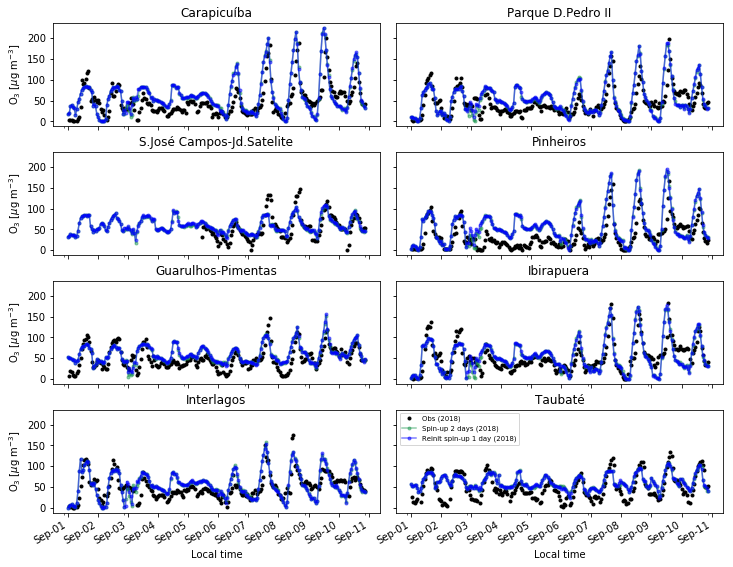

In [133]:
Timeplot(df1,df2)

In [114]:
poll = 'co'
label = 'CO [ppm]'
da_1 = df1[df1.station.isin(sites)][['local_date','Mday','station',poll+'_obs',poll+'_Fin']]
da_2 = df2[df2.station.isin(sites)][['local_date','Mday','station',poll+'_Rei']]
dfs = [da_1,da_2]
da = reduce(lambda left,right: pd.merge(left,right,on=['local_date','station','Mday']), dfs)
da.set_index('local_date', inplace=True)

In [115]:
da.dropna(inplace=True)

In [129]:
da

,Mday,station,co_obs,co_Fin,co_Rei
local_date,,,,,
2018-09-01 01:00:00-03:00,Sep-01-01,Ibirapuera,1.7,0.453325,0.453325
2018-09-01 02:00:00-03:00,Sep-01-02,Ibirapuera,1.4,0.433706,0.433706
2018-09-01 03:00:00-03:00,Sep-01-03,Ibirapuera,1.8,0.405137,0.405137
2018-09-01 04:00:00-03:00,Sep-01-04,Ibirapuera,1.9,0.432122,0.432122
2018-09-01 06:00:00-03:00,Sep-01-06,Ibirapuera,1.4,0.589057,0.589057
...,...,...,...,...,...
2018-09-10 17:00:00-03:00,Sep-10-17,Parque D.Pedro II,0.2,0.255951,0.259357
2018-09-10 18:00:00-03:00,Sep-10-18,Parque D.Pedro II,0.2,0.265355,0.267571
2018-09-10 19:00:00-03:00,Sep-10-19,Parque D.Pedro II,0.3,0.245358,0.249627


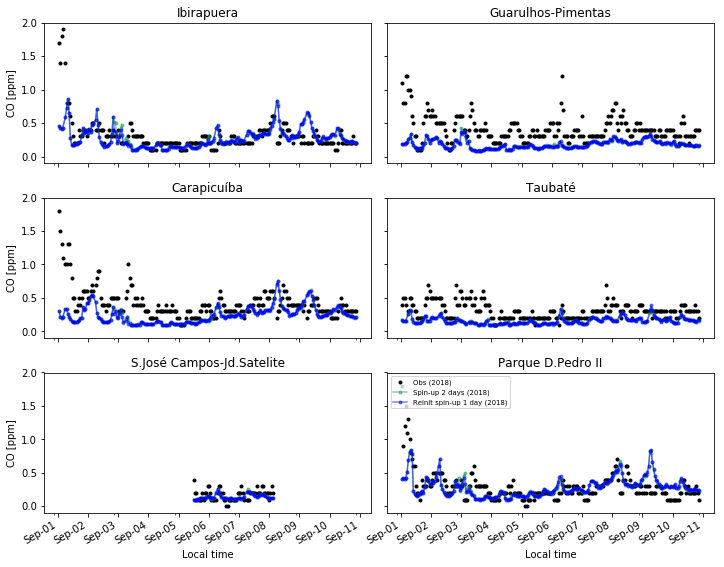

In [121]:
ncol = 3
fig, ax = plt.subplots(ncol,2, figsize=(12,10),sharex=True,sharey=True,gridspec_kw={'hspace':0.25,'wspace':0.05})
poll=poll
pol_label=label
colors = ['k','#229954','b']
legenda = ['Obs (2018)','Spin-up 2 days (2018)','Reinit spin-up 1 day (2018)']
sites = list(da.station.unique())
for i in range(ncol):
    da[da.station == sites[i]].iloc[:,2].plot(ax=ax[i,0],color=colors[0],marker='.', linestyle='None',
                                                  legend=False,title=sites[i])
    da[da.station == sites[i]].iloc[:,3:].plot(ax=ax[i,0],color=colors[1:],marker='.', alpha=0.5,
                                                legend=False,title=sites[i])
    da[da.station == sites[i+ncol]].iloc[:,2].plot(ax=ax[i,1], color=colors[0],marker='.',linestyle='None',
                                                legend=False,title=sites[i+ncol])
    da[da.station == sites[i+ncol]].iloc[:,3:].plot(ax=ax[i,1],color=colors[1:],marker='.', alpha=0.5,
                                                 legend=False,title=sites[i+ncol])
    ax[i,0].set_ylabel(pol_label)
    ax[i,0].set_xlabel('Local time')
    ax[i,1].set_xlabel('Local time')
    xfmt = md.DateFormatter('%b-%d')
    ax[i,0] = plt.gca()
    ax[i,0].xaxis.set_major_formatter(xfmt)
    ax[ncol-1,1].legend(legenda,loc=2,fontsize='x-small')
fig.savefig('../3_Results/fig/'+poll+'_comp.pdf',bbox_inches='tight')

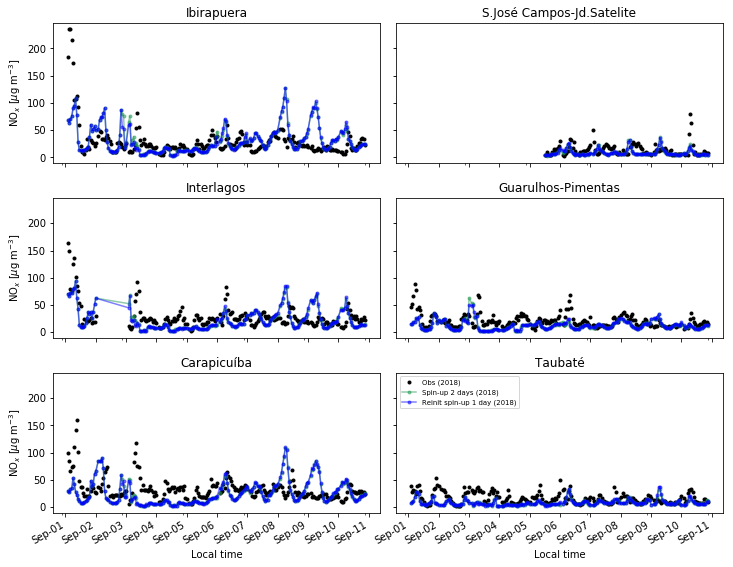

In [135]:
poll = 'nox'
label = 'NO$_x$ [$\mu$g m$^{-3}$]'
da_1 = df1[df1.station.isin(sites)][['local_date','Mday','station',poll+'_obs',poll+'_Fin']]
da_2 = df2[df2.station.isin(sites)][['local_date','Mday','station',poll+'_Rei']]
dfs = [da_1,da_2]
da = reduce(lambda left,right: pd.merge(left,right,on=['local_date','station','Mday']), dfs)
da.set_index('local_date', inplace=True)
da.dropna(inplace=True)

ncol = 3
fig, ax = plt.subplots(ncol,2, figsize=(12,10),sharex=True,sharey=True,gridspec_kw={'hspace':0.25,'wspace':0.05})
poll=poll
pol_label=label
colors = ['k','#229954','b']
legenda = ['Obs (2018)','Spin-up 2 days (2018)','Reinit spin-up 1 day (2018)']
sites = list(da.station.unique())
for i in range(ncol):
    da[da.station == sites[i]].iloc[:,2].plot(ax=ax[i,0],color=colors[0],marker='.', linestyle='None',
                                                  legend=False,title=sites[i])
    da[da.station == sites[i]].iloc[:,3:].plot(ax=ax[i,0],color=colors[1:],marker='.', alpha=0.5,
                                                legend=False,title=sites[i])
    da[da.station == sites[i+ncol]].iloc[:,2].plot(ax=ax[i,1], color=colors[0],marker='.',linestyle='None',
                                                legend=False,title=sites[i+ncol])
    da[da.station == sites[i+ncol]].iloc[:,3:].plot(ax=ax[i,1],color=colors[1:],marker='.', alpha=0.5,
                                                 legend=False,title=sites[i+ncol])
    ax[i,0].set_ylabel(pol_label)
    ax[i,0].set_xlabel('Local time')
    ax[i,1].set_xlabel('Local time')
    xfmt = md.DateFormatter('%b-%d')
    ax[i,0] = plt.gca()
    ax[i,0].xaxis.set_major_formatter(xfmt)
    ax[ncol-1,1].legend(legenda,loc=2,fontsize='x-small')
fig.savefig('../3_Results/fig/'+poll+'_comp.pdf',bbox_inches='tight')

Statistical analysis

In [74]:
def mod_Stats(data,mod_index = '_mod',polls=['o3','no','no2','co','tc','rh']):
    '''
    Statistics for model evaluation, according to Emery et al. (2017).
    
    Parameters
    ----------
    data: pandas DataFrame with parameter's suffixes '_obs' and '_mod'
    returns a pandas DataFrame
    '''
    '''
    Mean bias
    '''
    MB = []
    n = []
    for pol in polls:
        df = data[[pol+'_obs',pol+mod_index]].dropna()
        n.append(df[pol+'_obs'].count())
        MB.append(df[pol+'_obs'].mean()-df[pol+mod_index].mean())
    MB = pd.DataFrame([dict(zip(polls,MB))]).T.rename(columns={0:'MB'})
    n  = pd.DataFrame([dict(zip(polls,n))]).T.rename(columns={0:'n'})
    
    '''
    Mean Gross Error
    '''
    MGE = []
    for pol in polls:
        df = data[[pol+'_obs',pol+mod_index]].dropna()
        MGE.append((df[pol+mod_index] - df[pol+'_obs']).abs().mean())
    MGE = pd.DataFrame([dict(zip(polls,MGE))]).T.rename(columns={0:'MGE'})
    '''
    Root Mean Square Error
    '''
    RMSE = []
    for pol in polls:
        df = data[[pol+'_obs',pol+mod_index]].dropna()
        RMSE.append((((df[pol+mod_index] - df[pol+'_obs'])**2).mean())**0.5)
    RMSE = pd.DataFrame([dict(zip(polls,RMSE))]).T.rename(columns={0:'RMSE'})
    
    '''
    Normalized Mean Bias
    '''
    NMB = []
    for pol in polls:
        df = data[[pol+'_obs',pol+mod_index]].dropna()
        NMB.append( (df[pol+mod_index] - df[pol+'_obs']).sum() / df[pol+'_obs'].sum() * 100 )
    NMB = pd.DataFrame([dict(zip(polls,NMB))]).T.rename(columns={0:'NMB'})
    '''
    Normalized Mean Error
    '''
    NME = []
    for pol in polls:
        df = data[[pol+'_obs',pol+mod_index]].dropna()
        NME.append( ((df[pol+mod_index] - df[pol+'_obs']).abs().sum() /
                     df[pol+'_obs'].sum() * 100) )
    NME = pd.DataFrame([dict(zip(polls,NME))]).T.rename(columns={0:'NME'})
    '''
    Correlation coefficient using numpy
    '''
    r = []
    for pol in polls:
        df = data[[pol+'_obs',pol+mod_index]].dropna()
        r.append(np.corrcoef(df[pol+mod_index], df[pol+'_obs'])[0,1])
    r = pd.DataFrame([dict(zip(polls,r))]).T.rename(columns={0:'r'})
    '''
    Standard deviation
    '''
    Ostd = []
    Mstd = []
    for pol in polls:
        df = data[[pol+'_obs',pol+mod_index]].dropna()
        Ostd.append(df[pol+'_obs'].std())
        Mstd.append(df[pol+mod_index].std())
    Ostd = pd.DataFrame([dict(zip(polls,Ostd))]).T.rename(columns={0:'Obs SD'})
    Mstd = pd.DataFrame([dict(zip(polls,Mstd))]).T.rename(columns={0:'Mod SD'})
    ''' 
    Join
    '''
    stats = pd.concat([n,MB,MGE,RMSE,NMB,NME,r, Ostd, Mstd],axis=1).round(2)
    return stats 

In [75]:
da_1 = df1[df1.station.isin(sites)][['local_date','Mday','station',
                                     'o3_obs','co_obs','nox_obs','tc_obs','rh_obs','ws_obs',
                                     'o3_Fin','co_Fin','nox_Fin','tc_Fin','rh_Fin','ws_Fin']]
da_2 = df2[df2.station.isin(sites)][['local_date','Mday','station','o3_Rei','co_Rei','nox_Rei',
                                    'tc_Rei','rh_Rei','ws_Rei']]
dfs = [da_1,da_2]
da = reduce(lambda left,right: pd.merge(left,right,on=['local_date','station','Mday']), dfs)
da

,local_date,Mday,station,o3_obs,co_obs,nox_obs,tc_obs,rh_obs,ws_obs,o3_Fin,...,nox_Fin,tc_Fin,rh_Fin,ws_Fin,o3_Rei,co_Rei,nox_Rei,tc_Rei,rh_Rei,ws_Rei
0,2018-09-01 00:00:00-03:00,Sep-01-00,Ibirapuera,NaN,NaN,NaN,NaN,NaN,NaN,2.827378,...,82.846712,22.126495,48.989925,1.912495,2.827378,0.532704,82.846712,22.126495,48.989925,1.912495
1,2018-09-01 01:00:00-03:00,Sep-01-01,Ibirapuera,2.0,1.7,NaN,NaN,NaN,NaN,7.618124,...,71.035903,21.659973,51.882400,2.231953,7.618124,0.453325,71.035903,21.659973,51.882400,2.231953
2,2018-09-01 02:00:00-03:00,Sep-01-02,Ibirapuera,1.0,1.4,185.0,NaN,NaN,NaN,8.807626,...,68.011702,21.222687,53.629130,2.259550,8.807626,0.433706,68.011702,21.222687,53.629130,2.259550
3,2018-09-01 03:00:00-03:00,Sep-01-03,Ibirapuera,2.0,1.8,235.0,NaN,NaN,NaN,10.599191,...,63.686075,20.928955,54.501133,2.266714,10.599191,0.405137,63.686075,20.928955,54.501133,2.266714
4,2018-09-01 04:00:00-03:00,Sep-01-04,Ibirapuera,2.0,1.9,235.0,NaN,NaN,NaN,5.864894,...,70.319845,20.486664,55.905445,2.381194,5.864894,0.432122,70.319845,20.486664,55.905445,2.381194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,2018-09-10 17:00:00-03:00,Sep-10-17,Pinheiros,43.0,NaN,45.0,21.7,59.0,2.9,55.909700,...,24.523859,21.870850,65.476940,4.209442,59.741350,0.258199,25.058901,21.812317,64.938385,4.234623
1900,2018-09-10 18:00:00-03:00,Sep-10-18,Pinheiros,29.0,NaN,51.0,18.9,69.0,2.7,41.180920,...,25.570719,19.979431,72.622665,4.385832,42.854317,0.264566,26.566230,19.930573,72.713480,4.253406
1901,2018-09-10 19:00:00-03:00,Sep-10-19,Pinheiros,23.0,NaN,50.0,17.8,74.0,2.9,36.742650,...,26.298056,18.566467,76.861710,4.174801,37.064922,0.243423,26.596134,18.544190,77.221040,4.170641
1902,2018-09-10 20:00:00-03:00,Sep-10-20,Pinheiros,18.0,NaN,56.0,17.7,75.0,2.5,31.652521,...,27.881069,17.865082,79.625885,3.719324,32.314323,0.218058,25.556198,18.067200,81.216030,3.795312


In [76]:
mod_Stats(da,mod_index='_Fin',polls=['o3','co','nox','tc','rh','ws'])

,n,MB,MGE,RMSE,NMB,NME,r,Obs SD,Mod SD
o3,1744,-11.49,21.68,28.00,24.09,45.45,0.70,32.02,34.14
co,1217,0.11,0.17,0.24,-32.90,48.66,0.26,0.21,0.12
nox,1628,5.81,17.35,26.38,-20.44,61.01,0.37,24.55,20.84
tc,1553,-1.95,2.22,2.83,11.08,12.57,0.92,5.20,5.21
rh,1553,11.16,13.23,17.08,-15.50,18.38,0.77,19.05,18.68
ws,1553,-0.93,1.36,1.72,41.52,60.66,0.45,1.15,1.54


In [77]:
mod_Stats(da,mod_index='_Rei',polls=['o3','co','nox','tc','rh','ws'])

,n,MB,MGE,RMSE,NMB,NME,r,Obs SD,Mod SD
o3,1744,-11.82,21.79,28.18,24.79,45.67,0.70,32.02,34.03
co,1217,0.11,0.17,0.24,-32.88,48.59,0.26,0.21,0.12
nox,1628,5.81,17.44,26.47,-20.42,61.35,0.36,24.55,20.91
tc,1553,-1.98,2.24,2.87,11.22,12.70,0.92,5.20,5.24
rh,1553,11.58,13.57,17.41,-16.09,18.84,0.76,19.05,18.71
ws,1553,-0.92,1.35,1.72,41.38,60.60,0.45,1.15,1.54


#### September 2030 (NCAR CESM Bias-Corrected CMIP5 RCP4.5, ds316.1, 1 degree)

In [53]:
Dir = '../3_Results/RCP4.5/wrf_eval/'
f30_rcp45 = fnmatch.filter(os.listdir(Dir), '*rcp45*')
Mod_rcp45_30 = readMod(f30_rcp45, path = Dir)
Mod_rcp45_30.rename(columns={'name':'station'})
Mod_rcp45_30 = Mod_rcp45_30[['local_date','code','station','tc','rh','ws','wd','o3','no','no2','co']]
Mod_rcp45_30['nox'] = Mod_rcp45_30.no+Mod_rcp45_30.no2
Mod_rcp45_30['Mday']= Mod_rcp45_30.local_date.dt.strftime('%b-%d-%H')
Mod_rcp45_30.head()

,local_date,code,station,tc,rh,ws,wd,o3,no,no2,co,nox,Mday
0,2030-08-31 21:00:00-03:00,89,Campinas-Centro,21.394379,68.013916,6.192041,109.680620,50.109104,0.267513,5.853973,0.129423,6.121487,Aug-31-21
1,2030-08-31 22:00:00-03:00,89,Campinas-Centro,20.729462,69.964380,5.977874,110.393875,54.560616,0.183019,5.254651,0.128257,5.437670,Aug-31-22
2,2030-08-31 23:00:00-03:00,89,Campinas-Centro,20.401093,72.058174,5.691270,110.279236,60.053417,0.133154,4.753463,0.121096,4.886617,Aug-31-23
3,2030-09-01 00:00:00-03:00,89,Campinas-Centro,20.047485,75.667175,5.268250,105.235720,60.482460,0.116578,4.814149,0.119153,4.930728,Sep-01-00
4,2030-09-01 01:00:00-03:00,89,Campinas-Centro,19.931610,75.609276,5.277816,102.322530,60.365550,0.105263,4.543734,0.120539,4.648997,Sep-01-01


#### September 2030 (NCAR CESM Bias-Corrected CMIP5 RCP8.5, ds316.1, 1 degree)

In [54]:
Dir = '../3_Results/RCP8.5/wrf_eval/'
f30_rcp85 = fnmatch.filter(os.listdir(Dir), '*rcp85*')
Mod_rcp85_30 = readMod(f30_rcp85, path = Dir)
Mod_rcp85_30.rename(columns={'name':'station'})
Mod_rcp85_30 = Mod_rcp85_30[['local_date','code','station','tc','rh','ws','wd','o3','no','no2','co']]
Mod_rcp85_30['nox'] = Mod_rcp85_30.no+Mod_rcp85_30.no2
Mod_rcp85_30['Mday']= Mod_rcp85_30.local_date.dt.strftime('%b-%d-%H')
Mod_rcp85_30.head()

,local_date,code,station,tc,rh,ws,wd,o3,no,no2,co,nox,Mday
0,2030-08-31 21:00:00-03:00,277,S.José Campos-Jd.Satelite,21.529236,73.342285,2.575764,118.757355,60.383213,0.153986,14.139743,0.162838,14.293729,Aug-31-21
1,2030-08-31 22:00:00-03:00,277,S.José Campos-Jd.Satelite,19.656738,80.729065,4.609123,115.832596,62.120697,0.109946,5.985802,0.123611,6.095748,Aug-31-22
2,2030-08-31 23:00:00-03:00,277,S.José Campos-Jd.Satelite,19.000519,83.706180,4.721346,119.759970,69.388000,0.074570,4.000985,0.109368,4.075555,Aug-31-23
3,2030-09-01 00:00:00-03:00,277,S.José Campos-Jd.Satelite,18.716827,83.472725,4.402619,115.760640,65.564480,0.078284,4.223606,0.109992,4.301889,Sep-01-00
4,2030-09-01 01:00:00-03:00,277,S.José Campos-Jd.Satelite,17.904358,87.091095,3.437469,118.438290,53.653698,0.111306,6.029399,0.117881,6.140705,Sep-01-01


In [25]:
Mod_rcp85_30.nunique()

local_date     120
code            61
station         61
tc            7135
rh            7195
ws            7199
wd            7199
o3            7199
no            7200
no2           7200
co            7199
nox           7200
dtype: int64

## Figures

In [312]:
sites = ['Carapicuíba', 'S.José Campos-Jd.Satelite', 
            'Guarulhos-Pimentas','Interlagos',
            'Parque D.Pedro II', 'Pinheiros',
           'Ibirapuera','Taubaté']

#### 2018 (NCEP Final) vs 2030 (RCP4.5 and RCP8.5)

In [82]:
df1 = pd.merge(Obs, Mod_18, 
                on=['Mday','station','code','local_date'],
                suffixes=('_obs', '_Fin'))
df2 = pd.merge(Obs, Mod_rcp45_30, 
                on=['Mday','station','code'],
                suffixes=('_obs', '_rcp45'))
df3 = pd.merge(Obs, Mod_rcp85_30, 
                on=['Mday','station','code'],
                suffixes=('_obs', '_rcp85'))

print(df1.head(),df2.head(), df3.head())

                 local_date  tc_obs  rh_obs  sr  ws_obs  wd_obs  code  \
0 2018-09-01 00:00:00-03:00     NaN     NaN NaN     NaN     NaN    96   
1 2018-09-01 01:00:00-03:00     NaN     NaN NaN     NaN     NaN    96   
2 2018-09-01 02:00:00-03:00     NaN     NaN NaN     NaN     NaN    96   
3 2018-09-01 03:00:00-03:00     NaN     NaN NaN     NaN     NaN    96   
4 2018-09-01 04:00:00-03:00     NaN     NaN NaN     NaN     NaN    96   

          station  o3_obs  no_obs  ...       Mday     tc_Fin     rh_Fin  \
0  N.Senhora do Ó     NaN     NaN  ...  Sep-01-00  23.298310  44.076140   
1  N.Senhora do Ó     0.0     NaN  ...  Sep-01-01  22.410126  48.023920   
2  N.Senhora do Ó     0.0     NaN  ...  Sep-01-02  21.407288  52.332270   
3  N.Senhora do Ó     0.0     NaN  ...  Sep-01-03  20.983826  53.653320   
4  N.Senhora do Ó     0.0     NaN  ...  Sep-01-04  21.093628  51.141346   

     ws_Fin     wd_Fin     o3_Fin    no_Fin    no2_Fin    co_Fin    nox_Fin  
0  2.693815   7.026842  50.25502

### Surface ozone

In [345]:
def Timeplot(df1,df2,df3,poll='o3',label='O$_3$ [$\mu$g m$^{-3}$]', rcp_year='2030',sites=sites):
    da_1 = df1[df1.station.isin(sites)][['local_date','Mday','station',poll+'_obs',poll+'_Fin']]
    da_2 = df2[df2.station.isin(sites)][['Mday','station',poll+'_rcp45']]
    da_3 = df3[df3.station.isin(sites)][['Mday','station',poll+'_rcp85']]
    dfs = [da_1,da_2,da_3]
    da = reduce(lambda left,right: pd.merge(left,right,on=['station','Mday']), dfs)
    da.set_index('local_date', inplace=True)
    fig, ax = plt.subplots(4,2, figsize=(12,10),sharex=True,sharey=True,gridspec_kw={'hspace':0.25,'wspace':0.05})
    poll=poll
    pol_label=label
    colors = ['k','#229954','#86B2D6','#D22523']
    legenda = ['Obs (2018)','NCEP Fin (2018)','RCP4.5 '+rcp_year,'RCP8.5 '+rcp_year]

    for i in range(4):
        da[da.station == sites[i]].iloc[:,2].plot(ax=ax[i,0],color=colors[0],marker='.', linestyle='None',
                                                  legend=False,title=sites[i])
        da[da.station == sites[i]].iloc[:,3:].plot(ax=ax[i,0],color=colors[1:],marker='.', alpha=0.5,
                                                  legend=False,title=sites[i])
        da[da.station == sites[i+4]].iloc[:,2].plot(ax=ax[i,1], color=colors[0],marker='.',linestyle='None',
                                                    legend=False,title=sites[i+4])
        da[da.station == sites[i+4]].iloc[:,3:].plot(ax=ax[i,1],color=colors[1:],marker='.', alpha=0.5,
                                                     legend=False,title=sites[i+4])
        ax[i,0].set_ylabel(pol_label)
        ax[i,0].set_xlabel('Local time')
        ax[i,1].set_xlabel('Local time')
        xfmt = md.DateFormatter('%b-%d')
        ax[i,0] = plt.gca()
        ax[i,0].xaxis.set_major_formatter(xfmt)
        ax[3,1].legend(legenda,loc=2,fontsize='x-small')
    fig.savefig('../3_Results/fig/'+poll+'_Res.pdf',bbox_inches='tight')

In [385]:
def TimePlot(df1,df2,df3,poll='co', label='CO [ppm]', rcp_year='2030',sites=sites):
    fig=plt.figure(figsize=(12,10))
    columns = 2
    rows = 4
    poll= poll
    pol_label=label

    da_1 = df1[df1.station.isin(sites)][['local_date','Mday','station',poll+'_obs',poll+'_Fin']]
    da_2 = df2[df2.station.isin(sites)][['Mday','station',poll+'_rcp45']]
    da_3 = df3[df3.station.isin(sites)][['Mday','station',poll+'_rcp85']]
    dfs = [da_1,da_2,da_3]
    da = reduce(lambda left,right: pd.merge(left,right,on=['station','Mday']), dfs)
    da.set_index('local_date', inplace=True)
    #############
    for i in range(1, len(stations)+1):
        ax=fig.add_subplot(rows, columns, 1)
        fig.add_subplot(rows, columns, i,sharex=ax, sharey=ax)
        df=da[da.station == sites[i-1]][[poll+'_obs',poll+'_Fin',poll+'_rcp45',poll+'_rcp85']]
        plt.plot(df[poll+'_obs'  ],'ko', label = 'Obs', markersize=4)
        plt.plot(df[poll+'_Fin'  ],'o-', c='#229954', label = 'NCEP Fin (2018)',markersize=4, linewidth=2, alpha = 0.5)
        plt.plot(df[poll+'_rcp45'],'o-', c='#86B2D6', label = 'RCP4.5 '+rcp_year,markersize=4, linewidth=2, alpha = 0.5)
        plt.plot(df[poll+'_rcp85'],'o-', c='#D22523', label = 'RCP8.5 '+rcp_year,markersize=4, linewidth=2, alpha = 0.5)
        if i == len(sites):
            plt.legend(fontsize=8)
        plt.ylabel(pol_label)
        plt.title(sites[i-1])
        xfmt = md.DateFormatter('%b-%d')
        ax = plt.gca()
        ax.xaxis.set_major_formatter(xfmt)
        fig.subplots_adjust(hspace=0.4)
    #############
    fig.savefig("../3_Results/fig/"+poll+"_res.pdf",bbox_inches='tight')

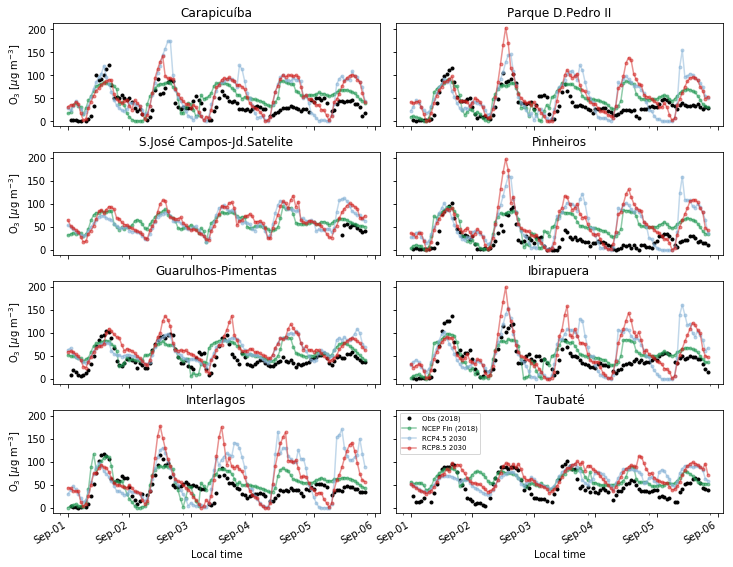

In [380]:
Timeplot(df1,df2,df3)

### NOx

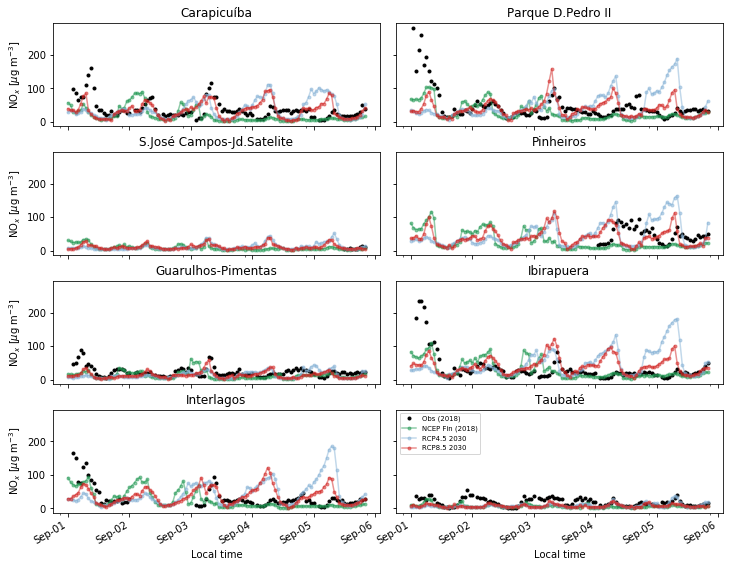

In [382]:
Timeplot(df1,df2,df3,poll='nox',label='NO$_x$ [$\mu$g m$^{-3}$]', rcp_year='2030',sites=sites)

### CO

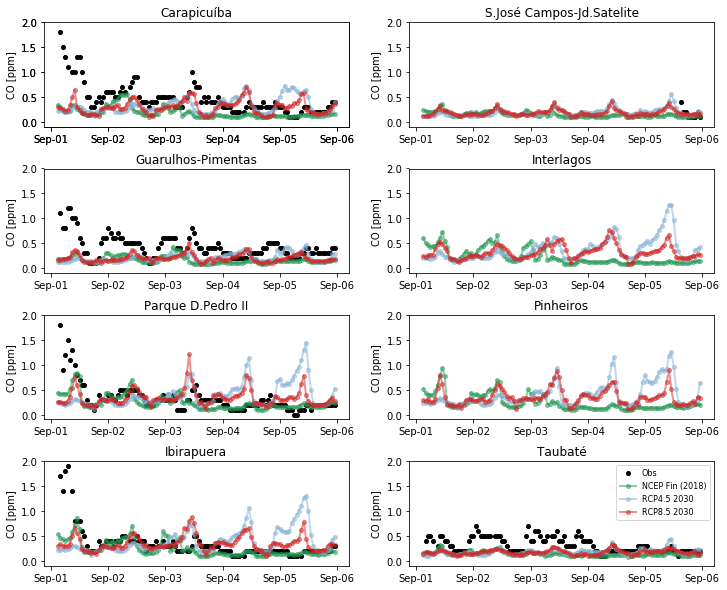

In [386]:
TimePlot(df1,df2,df3,poll='co',label='CO [ppm]', rcp_year='2030',sites=sites)

### Meteorology parameters

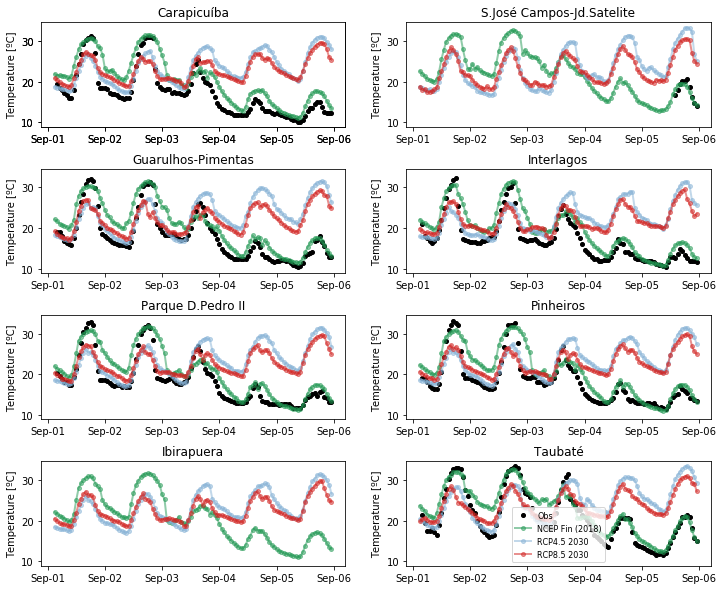

In [387]:
TimePlot(df1,df2,df3,poll='tc',label='Temperature [ºC]', rcp_year='2030',sites=sites)

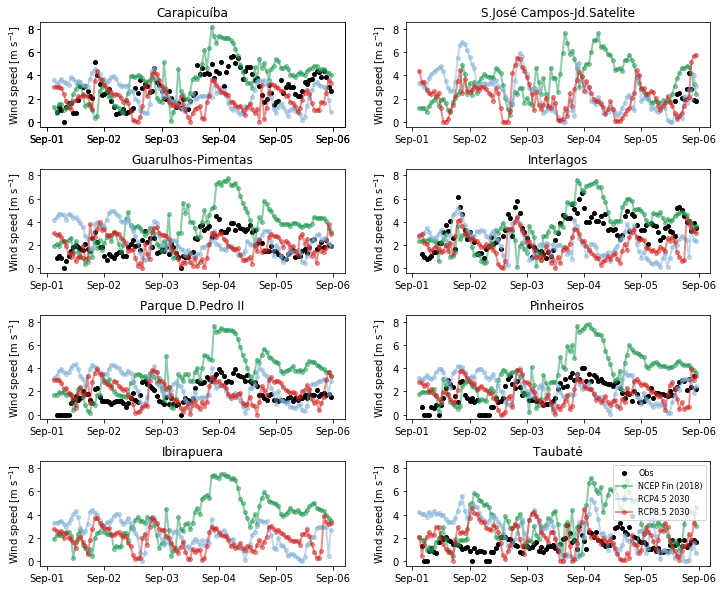

In [388]:
TimePlot(df1,df2,df3,poll='ws',label='Wind speed [m s$^{-1}$]', rcp_year='2030',sites=sites)

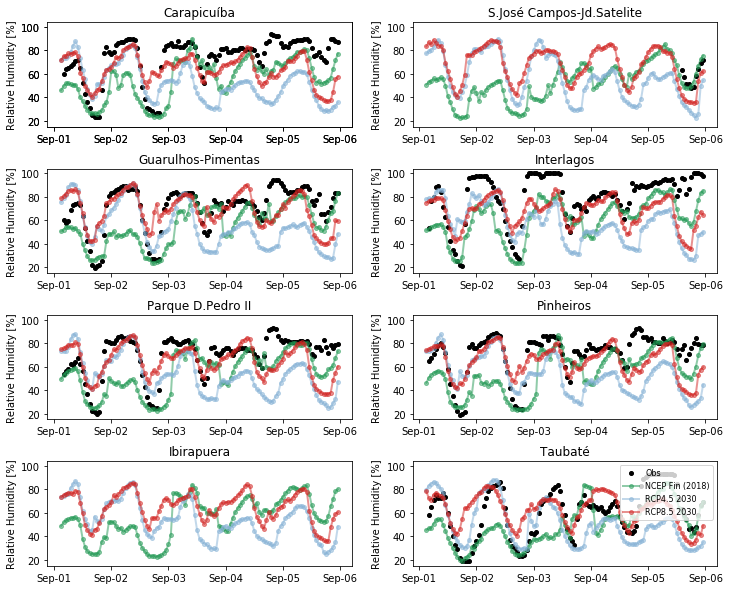

In [390]:
TimePlot(df1,df2,df3,poll='rh',label='Relative Humidity [%]', rcp_year='2030',sites=sites)